In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
from unidecode import unidecode
import os
from datetime import date
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

Taux de doublons : 3.84%
full_2017.csv
Taux de doublons : 3.57%
full_2018.csv
Taux de doublons : 3.9%
full_2019.csv
Taux de doublons : 4.05%
full_2020.csv
Taux de doublons : 7.31%
full_2021.csv
Taux de doublons : 7.07%
full_2022.csv


,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2017-1,2017-07-04,000001,Vente,166100.0,843,NaN,RUE DE LA CHARPINE,0100,01000,01344,Saint-Denis-lès-Bourg,01,NaN,NaN,01344000AK0534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,Maison,73.0,4.0,S,sols,NaN,NaN,391.0,5.204386,46.193683
1,2017-2,2017-07-06,000001,Vente,59000.0,2,NaN,RUE GOUNOD,1720,01000,01053,Bourg-en-Bresse,01,NaN,NaN,01053000AL0175,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,5.219932,46.196098
2,2017-2,2017-07-06,000001,Vente,59000.0,2,NaN,RUE GOUNOD,1720,01000,01053,Bourg-en-Bresse,01,NaN,NaN,01053000AL0175,NaN,NaN,45,32.32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,32.0,1.0,NaN,NaN,NaN,NaN,NaN,5.219932,46.196098
3,2017-3,2017-07-07,000001,Vente terrain à bâtir,55000.0,NaN,NaN,LA MAGDELEINE,B033,01160,01430,Varambon,01,NaN,NaN,014300000B0831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AB,terrains a bâtir,NaN,NaN,605.0,5.304674,46.040624
4,2017-4,2017-07-06,000001,Vente,130000.0,NaN,NaN,HAMEAU DU CREUX EST,B148,01750,01320,Replonges,01,NaN,NaN,013200000D4182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,AG,terrains d'agrément,NaN,NaN,259.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429088,2022-537271,2022-06-21,000001,Vente,423000.0,43,NaN,RUE DES FAVORITES,3536,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,16,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454
1429089,2022-537271,2022-06-21,000001,Vente,423000.0,43,NaN,RUE DES FAVORITES,3536,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000AC0055,NaN,NaN,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.305379,48.837454
1429090,2022-537272,2022-06-30,000001,Vente,104650.0,50,NaN,RUE LEON FROT,5554,75011,75111,Paris 11e Arrondissement,75,NaN,NaN,75111000BS0234,NaN,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,15.0,1.0,NaN,NaN,NaN,NaN,NaN,2.386354,48.856079
1429091,2022-537273,2022-02-10,000001,Adjudication,51000.0,12,NaN,SQ HENRY PATE,4608,75016,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000BY0016,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,2.271505,48.849026


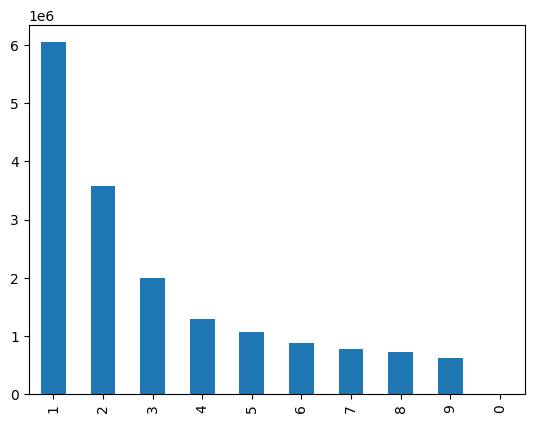

In [13]:
df = pd.DataFrame(None)
for f in [k for k in os.listdir() if 'full_' in k]:
    _ = pd.read_csv(f, 
                    sep=',', 
                    encoding= 'utf8',
                    dtype=str,
                   )
    len_brute = len(_)
    _ = _.drop_duplicates()
    print(f'Taux de doublons : {round(100*(1-len(_)/len_brute), 2)}%') ## 4% de doublons par an
    df= pd.concat([df, _])
    print(f)
## Benford
benford = df['valeur_fonciere'].str.slice(0,1).value_counts(dropna=True).map(int)
benford /= sum(benford)
benford.plot.bar()
to_cast = [
    'valeur_fonciere',
    'nombre_pieces_principales',
    'longitude',
    'latitude',
] + [c for c in df.columns if 'surface_' in c]
df.loc[:, to_cast] = df.loc[:, to_cast].astype(float)
df

In [14]:
## mutations et types de biens
cross_list = ['nature_mutation', 'type_local']
df[cross_list].value_counts(dropna=False).reset_index().sort_values(by=cross_list)

cross_list = ['nature_mutation', 'nature_culture']
df[cross_list].value_counts(dropna=False).reset_index().sort_values(by=cross_list)

,nature_mutation,code_type_local,0
12,Adjudication,1,11723
14,Adjudication,2,11330
16,Adjudication,3,8076
20,Adjudication,4,3680
11,Adjudication,NaN,15784
19,Echange,1,6232
18,Echange,2,6537
15,Echange,3,8485
21,Echange,4,2387
7,Echange,NaN,178148


In [25]:
## répartition des valeurs
## on sort les doublons de mutations pour ne pas biaiser avec les mutations
# df_prix = df.drop_duplicates(subset='id_mutation')
print("Pas de valeur :", round(len(df_prix.loc[df_prix['valeur_fonciere'].isna()])/len(df_prix)*100, 2), "%")
repartition={}
for k in range(0, 11):
    repartition[10**(k-1)]= len(df_prix.loc[df_prix['valeur_fonciere'].between(10**(k-1), (10**k)/4, inclusive='right')])
    repartition[(10**k)/4]= len(df_prix.loc[df_prix['valeur_fonciere'].between((10**k)/4, (10**k)/2, inclusive='right')])
    repartition[(10**k)/2]= len(df_prix.loc[df_prix['valeur_fonciere'].between((10**k)/2, 10**k, inclusive='right')])
    print(f'entre {10**(k-1)}€ et {10**k}€ :', repartition[10**(k-1)]+repartition[(10**k)/4]+repartition[(10**k)/2])
df_rep = pd.DataFrame({'prix': repartition.keys(), 'nb': repartition.values()})
df_rep

Pas de valeur : 0.27 %
entre 0.1€ et 1€ : 45580
entre 1€ et 10€ : 4422
entre 10€ et 100€ : 28593
entre 100€ et 1000€ : 187191
entre 1000€ et 10000€ : 495608
entre 10000€ et 100000€ : 2014354
entre 100000€ et 1000000€ : 4445900
entre 1000000€ et 10000000€ : 112885
entre 10000000€ et 100000000€ : 5307
entre 100000000€ et 1000000000€ : 285
entre 1000000000€ et 10000000000€ : 4


,prix,nb
0,1.000000e-01,218
1,2.500000e-01,59
2,5.000000e-01,45303
3,1.000000e+00,1750
4,2.500000e+00,703
5,5.000000e+00,1969
6,1.000000e+01,3739
7,2.500000e+01,7408
8,5.000000e+01,17446
9,1.000000e+02,33956


In [27]:
fig = go.Figure(data=[go.Bar(
    x=df_rep['prix'],
    y=df_rep['nb'],
    width=df_rep['prix']/2,
#     tickmode = 'array',
#     tickvals = df_rep['prix'],
#     ticktext = [f"{k}€" for k in df_rep['prix']]
)])
fig.update_xaxes(type='log')
fig.update_yaxes(type='log')
fig.show()

In [70]:
df.loc[df['valeur_fonciere']<1]['type_local'].value_counts(dropna=False)

NaN                                         1085
Local industriel. commercial ou assimilé     338
Appartement                                   73
Dépendance                                    20
Maison                                        14
Name: type_local, dtype: int64

In [28]:
## repartition des surfaces
print("Pas de valeur :", round(len(df.loc[df['surface_reelle_bati'].isna()])/len(df)*100, 2), "%")
repartition_surf={}
for k in range(0, 7):
    repartition_surf[10**(k-1)]= len(df.loc[df['surface_reelle_bati'].between(10**(k-1), (10**k)/2, inclusive='right')])
    repartition_surf[(10**k)/2]= len(df.loc[df['surface_reelle_bati'].between((10**k)/2, 10**k, inclusive='right')])
    print(f'entre {10**(k-1)}m² et {10**k}m² :', repartition[10**(k-1)]+repartition[(10**k)/2])
df_rep_surf = pd.DataFrame({'surface': repartition_surf.keys(), 'nb': repartition_surf.values()})
df_rep_surf

Pas de valeur : 60.96 %
entre 0.1m² et 1m² : 45521
entre 1m² et 10m² : 3719
entre 10m² et 100m² : 21185
entre 100m² et 1000m² : 125192
entre 1000m² et 10000m² : 331948
entre 10000m² et 100000m² : 1501480
entre 100000m² et 1000000m² : 3183535


,surface,nb
0,0.1,0
1,0.5,1766
2,1.0,5631
3,5.0,27045
4,10.0,1666730
5,50.0,3087601
6,100.0,1816110
7,500.0,40394
8,1000.0,39278
9,5000.0,5100


In [29]:
fig = go.Figure(data=[go.Bar(
    x=df_rep_surf['surface'],
    y=df_rep_surf['nb'],
    width=df_rep_surf['surface']/2,
)])
fig.update_xaxes(type='log')
fig.update_yaxes(type='log')
fig.show()

In [32]:
### lots, bâti, pièces

print("aucune surface de bien renseignée")
cols_of_interest = [c for c in df.columns if any([s in c for s in ['surface_reelle', 'surface_carrez']])]
print(df.loc[df[[surf_col for surf_col in cols_of_interest]].isna().all(axis=1)]['type_local'].value_counts(dropna=True))

print("\naucune surface")
cols_of_interest = [c for c in df.columns if 'surface' in c]
print(df.loc[df[[surf_col for surf_col in cols_of_interest]].isna().all(axis=1)]['type_local'].value_counts(dropna=False))

print("\npas de surface de bâti mais au moins un lot a une surface (dépendances ok ?)")
cols_of_interest = [c for c in df.columns if 'surface_carrez' in c]
print(df.loc[(df['surface_reelle_bati'].isna()) & (~(df[[surf_col for surf_col in cols_of_interest]].isna()).all(axis=1))]['type_local'].value_counts(dropna=True))

print("\nun lot a une plus grande surface que le bâti")
cols_of_interest = [c for c in df.columns if 'surface_carrez' in c]
print(df.loc[df[[surf_col for surf_col in cols_of_interest]].max(axis=1) > 1.05*df['surface_reelle_bati']]['type_local'].value_counts(dropna=True))

print('\nappartement ou maison sans nombre de pièces')
print(df.loc[df['code_type_local'].isin(['1','2']) & df['nombre_pieces_principales'].isna()])

aucune surface de bien renseignée
Dépendance                                  2414237
Local industriel. commercial ou assimilé      32382
Appartement                                     148
Maison                                           51
Name: type_local, dtype: int64
aucune surface
Dépendance                                  1813822
Local industriel. commercial ou assimilé        813
Appartement                                     136
Maison                                            5
Name: type_local, dtype: int64


In [76]:
# types
print("aucun type renseigné")
no_type = df.loc[(df['code_type_local'].isna()) & (df['code_nature_culture'].isna()) & (df['code_nature_culture_speciale'].isna())]
print(round(len(no_type)/len(df)*100, 2), "% du nombre de lignes")

print("mutations sans type")
full_no_type = pd.DataFrame(None)
for c in ['code_type_local', 'code_nature_culture', 'code_nature_culture_speciale']:
    if len(full_no_type)==0:
        full_no_type = df.loc[df['id_mutation'].isin(no_type['id_mutation'])].groupby('id_mutation')[c].apply(list).reset_index()
    else:
        full_no_type = pd.merge(full_no_type, df.loc[df['id_mutation'].isin(no_type['id_mutation'])].groupby('id_mutation')[c].apply(list).reset_index(), on='id_mutation', how='outer')

full_no_type = full_no_type.loc[pd.Series(np.product([full_no_type[c].apply(lambda l: all([not(isinstance(k, str)) for k in l])) for c in full_no_type.columns if 'code_' in c], axis=0)).astype(bool)]
print(round(len(full_no_type)/len(df['id_mutation'].drop_duplicates())*100, 2), "% du nombre de mutations")
print("natures mutations de ces biens :")
print(df.loc[df['id_mutation'].isin(full_no_type['id_mutation'])]['nature_mutation'].value_counts(dropna=False))
full_no_type

aucun type renseigné
5.01 %
mutations sans type
4.52 %
natures mutations de ces biens :
Vente en l'état futur d'achèvement    794327
Vente                                  24130
Expropriation                            956
Echange                                  836
Vente terrain à bâtir                    124
Adjudication                              24
Name: nature_mutation, dtype: int64


,id_mutation,code_type_local,code_nature_culture,code_nature_culture_speciale
2,2017-100055,"[nan, nan]","[nan, nan]","[nan, nan]"
3,2017-100056,"[nan, nan]","[nan, nan]","[nan, nan]"
4,2017-100083,"[nan, nan]","[nan, nan]","[nan, nan]"
5,2017-100123,"[nan, nan]","[nan, nan]","[nan, nan]"
6,2017-100248,"[nan, nan]","[nan, nan]","[nan, nan]"
...,...,...,...,...
355224,2022-99894,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
355225,2022-99895,[nan],[nan],[nan]
355226,2022-99936,"[nan, nan, nan]","[nan, nan, nan]","[nan, nan, nan]"
355227,2022-99947,"[nan, nan]","[nan, nan]","[nan, nan]"


In [80]:
df.loc[df['id_mutation']=='2017-165267']

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
414958,2017-165267,2017-10-07,000001,Vente,66700.0,5842,F,RTE DU TREUSTEL,0842,29120,29037,Combrit,29,NaN,NaN,29037000AH0454,NaN,NaN,117,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.153689,47.866252
414959,2017-165267,2017-10-07,000001,Vente,66700.0,NaN,NaN,PEN DIRY,B171,29120,29037,Combrit,29,NaN,NaN,29037000AH0454,NaN,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3,Dépendance,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-4.153689,47.866252


In [77]:
df.loc[(df['id_mutation'].isin(full_no_type['id_mutation'])) & (df['nature_mutation']=='Vente')]

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
3088,2017-1317,2017-10-19,000001,Vente,110000.0,NaN,NaN,COLIGNY LE HAUT,B050,01270,01108,Coligny,01,NaN,NaN,01108000AD0044,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.344019,46.382684
3089,2017-1317,2017-10-19,000001,Vente,110000.0,NaN,NaN,COLIGNY LE HAUT,B050,01270,01108,Coligny,01,NaN,NaN,01108000AD0044,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.344019,46.382684
9393,2017-3681,2017-09-29,000001,Vente,224000.0,NaN,NaN,NaN,NaN,NaN,01079,Champagne-en-Valromey,01,NaN,NaN,010790000B0351,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.67852,45.904331
9810,2017-3870,2017-10-11,000001,Vente,70000.0,27,NaN,CHE DE LA PLANCHE BRULEE,0055,01210,01160,Ferney-Voltaire,01,NaN,NaN,01160000AC0108,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.099265,46.250559
9909,2017-3918,2017-09-21,000001,Vente,143000.0,NaN,NaN,LE VILLAGE,B141,01100,01014,Arbent,01,NaN,NaN,01014000AB0076,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.681806,46.295845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420158,2022-532925,2022-04-27,000001,Vente,25188088.0,1,B,BD VICTOR,9743,75015,75115,Paris 15e Arrondissement,75,NaN,NaN,75115000EX0008,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.278984,48.836326
1420445,2022-533065,2022-05-13,000001,Vente,830000.0,24,NaN,RUE DU TEXEL,9224,75014,75114,Paris 14e Arrondissement,75,NaN,NaN,75114000DQ0150,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.32006,48.836253
1425827,2022-535799,2022-06-24,000001,Vente,1673550.6,4,NaN,RUE GERMAINE KRULL,4167,75013,75113,Paris 13e Arrondissement,75,NaN,NaN,75113000DA0121,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.358891,48.817215
1427435,2022-536522,2022-05-23,000001,Vente,16342800.0,13,NaN,RUE DE L ASSOMPTION,0503,75016,75116,Paris 16e Arrondissement,75,NaN,NaN,75116000BU0056,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.273617,48.853092


In [79]:
## appartement ou maison sans nombre de pièces
df.loc[df['code_type_local'].isin(['1','2']) & df['nombre_pieces_principales'].isna()]

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,ancien_code_commune,ancien_nom_commune,id_parcelle,ancien_id_parcelle,numero_volume,lot1_numero,lot1_surface_carrez,lot2_numero,lot2_surface_carrez,lot3_numero,lot3_surface_carrez,lot4_numero,lot4_surface_carrez,lot5_numero,lot5_surface_carrez,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
69556,2017-29947,2017-08-07,000001,Vente en l'état futur d'achèvement,340000.0,27,NaN,BD CHARLES GUILLAUMONT,0690,06160,06004,Antibes,06,NaN,NaN,06004000CP0343,NaN,NaN,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.105279,43.570556
163706,2017-64713,2017-07-04,000001,Vente,430500.0,17,NaN,RUE ERNEST RENAN,3189,13005,13205,Marseille 5e Arrondissement,13,NaN,NaN,132058190E0231,NaN,NaN,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39351,43.28695
172305,2017-69513,2017-10-12,000001,Vente,205000.0,14,NaN,AV DE LA BARQUIERE,0762,13009,13209,Marseille 9e Arrondissement,13,NaN,NaN,132098520B0200,NaN,NaN,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.39828,43.244482
414958,2017-165267,2017-10-07,000001,Vente,66700.0,5842,F,RTE DU TREUSTEL,0842,29120,29037,Combrit,29,NaN,NaN,29037000AH0454,NaN,NaN,117,38.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.153689,47.866252
483478,2017-195408,2017-12-15,000001,Vente,18000.0,23,NaN,AV DES ETATS UNIS,3104,31200,31555,Toulouse,31,NaN,NaN,31555829AX0158,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.432834,43.628084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272586,2021-1571443,2021-03-16,000001,Vente,320000.0,17,NaN,LOT LONY,A080,97354,97309,Remire-Montjoly,973,NaN,NaN,97309000AC0784,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,NaN,NaN,S,sols,NaN,NaN,1059.0,-52.282859,4.922113
4286342,2021-1577237,2021-10-14,000001,Vente,350000.0,13,NaN,ALL DES OPALES,1027,97400,97411,Saint-Denis,974,NaN,NaN,97411000DE0250,NaN,NaN,8,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.445232,-20.892732
640442,2022-230107,2022-06-01,000001,Vente,372500.0,24,NaN,MAIL SUD,0978,45300,45252,Pithiviers,45,NaN,NaN,45252000AK0106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2,Appartement,NaN,NaN,S,sols,NaN,NaN,229.0,2.255575,48.171167
902184,2022-330880,2022-04-29,000001,Vente,146220.0,41,NaN,AV JACQUES DUCLOS,0855,69200,69259,Vénissieux,69,NaN,NaN,69259000BS0110,NaN,NaN,9,42.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,Appartement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.894086,45.698423
